In [ ]:
# !pip install kmodes 

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/1001 Capstone

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/1001 Capstone


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
import scipy.stats as stats
import random
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,auc, roc_curve
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes

import warnings
warnings.filterwarnings('ignore')

In [ ]:
random.seed(17312218)

In [ ]:
df = pd.read_csv("dataset.csv")

### Preprocessing

In [ ]:
def preprocessing(df,expand_artist = False):
  df = df.dropna()
  df = df.drop('Unnamed: 0',axis = 1)
  med = df["acousticness"].median() 
  df["accoustic_dummy"] = [1 if x > med else 0 for x in df["acousticness"]]
  med = df["danceability"].median() 
  df["danceability_dummy"] = [1 if x > med else 0 for x in df["danceability"]]
  med = df["tempo"].median() 
  df["tempo_dummy"]=  [1 if x > med else 0 for x in df["tempo"]]
  df["explicit"] = df["explicit"].apply(lambda x: 1 if x == True else 0)
  df["track_genre"] = df["track_genre"].astype('category')
  if expand_artist:
    df['artists'] = df["artists"].str.split(';')
    df = df.explode("artists")
  return df

In [ ]:
df = preprocessing(df,True)

### EDA

(array([2.643e+04, 2.587e+03, 1.483e+03, 1.313e+03, 1.433e+03, 2.010e+03,
        1.927e+03, 1.532e+03, 2.810e+03, 4.028e+03, 6.131e+03, 5.900e+03,
        4.563e+03, 4.067e+03, 3.634e+03, 3.086e+03, 3.314e+03, 3.731e+03,
        4.085e+03, 4.826e+03, 5.151e+03, 5.495e+03, 6.034e+03, 5.404e+03,
        4.894e+03, 4.586e+03, 4.014e+03, 4.160e+03, 4.384e+03, 3.960e+03,
        3.309e+03, 3.070e+03, 2.720e+03, 2.554e+03, 1.921e+03, 1.662e+03,
        1.356e+03, 1.293e+03, 1.027e+03, 7.020e+02, 5.710e+02, 4.610e+02,
        2.850e+02, 1.420e+02, 1.060e+02, 6.400e+01, 2.600e+01, 1.600e+01,
        2.900e+01]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

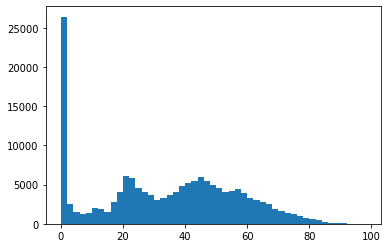

In [ ]:
# Popularity in General
plt.hist(df["popularity"], range(0,100,2))

In [ ]:
# Every Genre has the same number of counts
df.groupby("track_genre")["track_id"].count()

track_genre
acoustic       1145
afrobeat       1309
alt-rock       1082
alternative    1158
ambient        1439
               ... 
techno         1495
trance         1833
trip-hop       1344
turkish        1244
world-music    1429
Name: track_id, Length: 114, dtype: int64

In [ ]:
df.track_genre.unique().shape

(114,)

The mean popularity for all songs is 33.33344704722917


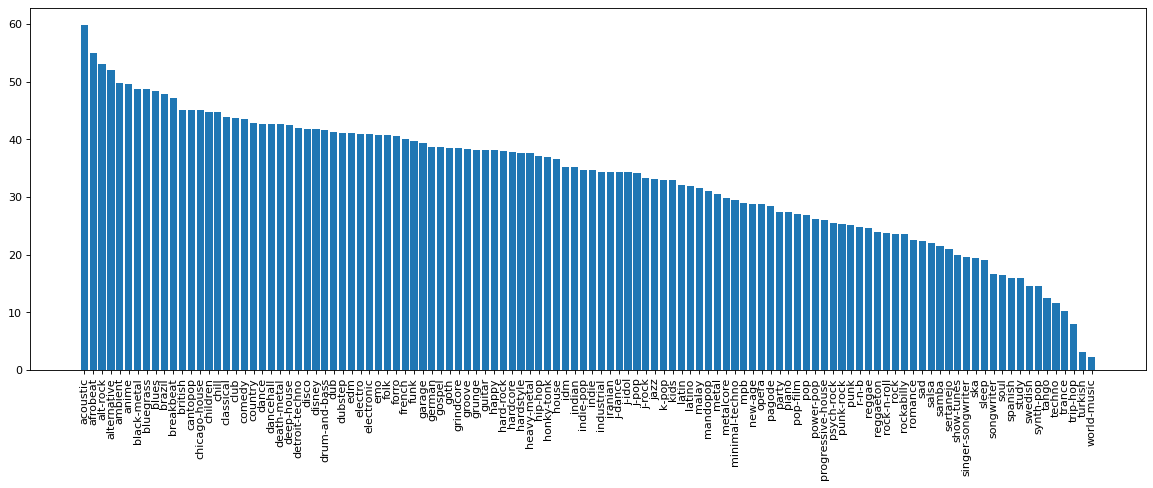

In [ ]:
# Popularity by Genre. Use average popularity.
avg_pop_all = df["popularity"].mean()
figure(figsize=(18, 6), dpi=80)
# df[["track_genre","popularity"]].groupby("track_genre").mean().plot(kind='bar', color='blue')
# df["popularity"].mean()
pop_by_genre = df[["track_genre","popularity"]].groupby("track_genre").mean().sort_values(by = "popularity",ascending = False)
plt.bar(df.track_genre.unique(),pop_by_genre.squeeze())
plt.xticks(rotation=90)
print(f"The mean popularity for all songs is {avg_pop_all}")

Text(0, 0.5, 'Popularity')

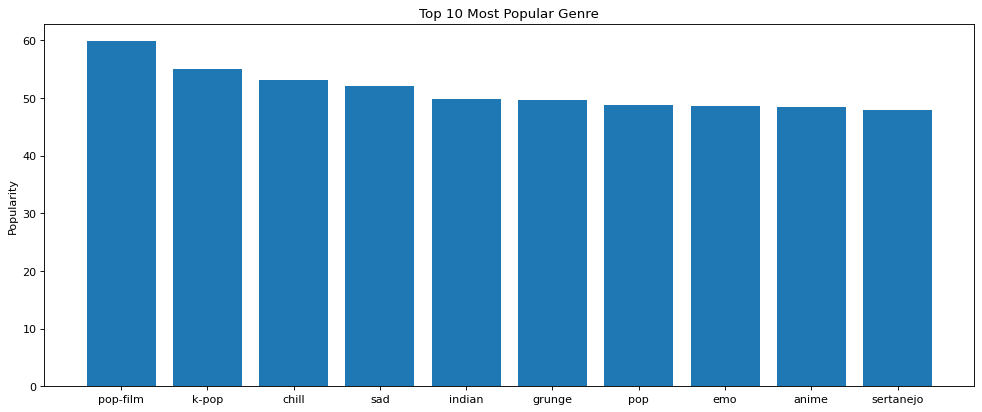

In [ ]:
# Top 10 most popular genre: Three of them are "pop musics", which is why they are popular
figure(figsize=(15, 6), dpi=80)
plt.bar(pop_by_genre.index[:10],pop_by_genre[:10].squeeze())
plt.title("Top 10 Most Popular Genre")
plt.ylabel("Popularity")

<BarContainer object of 10 artists>

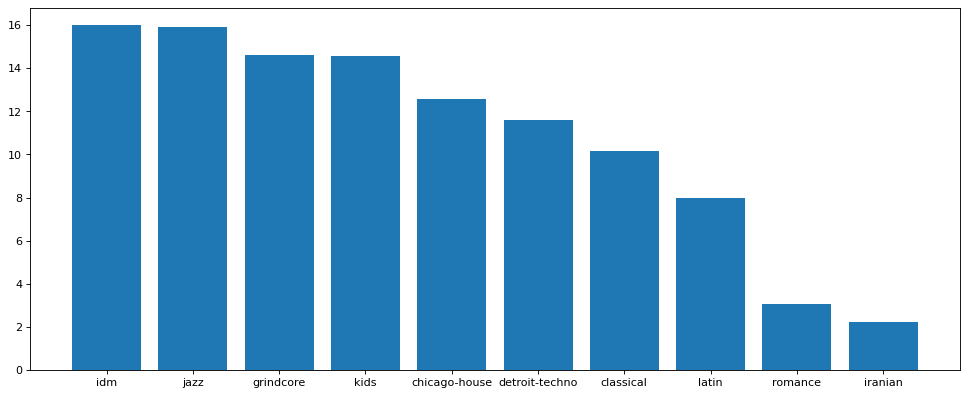

In [ ]:
# Bottom 10 least popular genre: Jazz is one of it.. emmm
figure(figsize=(15, 6), dpi=80)
plt.bar(pop_by_genre.index[-10:],pop_by_genre[-10:].squeeze())

<BarContainer object of 10 artists>

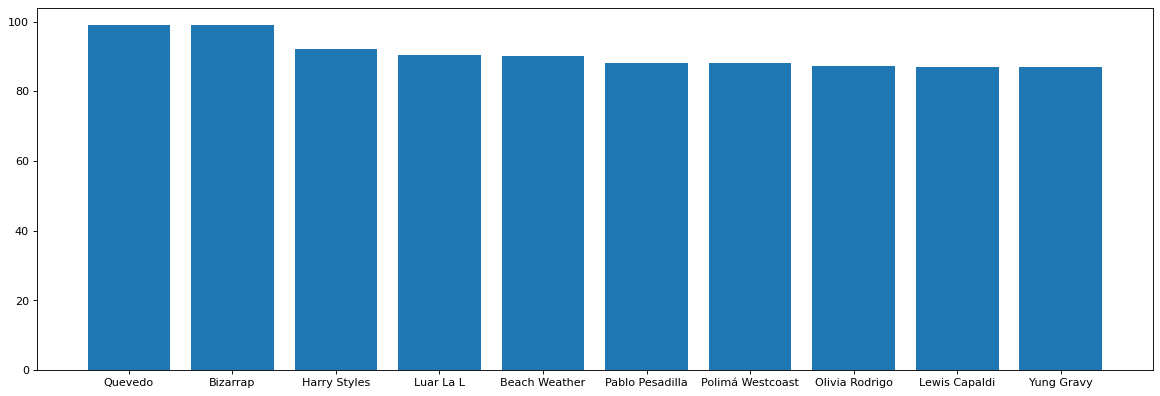

In [ ]:
# Top artists with highest avg pop
avg_pop = df[['artists','popularity']].groupby("artists").mean().sort_values(by = "popularity",ascending = False)
figure(figsize=(18, 6), dpi=80)
plt.bar(avg_pop.index[:10],avg_pop[:10].squeeze())

### Inference Question

Text(0.5, 1.0, 'More Danceability')

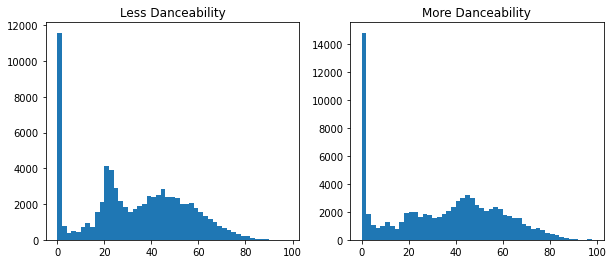

In [ ]:
# Test 0: Would more danceability have higher popularity?
fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].hist(df.loc[df["danceability_dummy"]==0,"popularity"],range(0,100,2))
ax[0].set_title("Less Danceability")
ax[1].hist(df.loc[df["danceability_dummy"]==1,"popularity"],range(0,100,2))
ax[1].set_title("More Danceability")

Text(0, 0.5, 'Popularity')

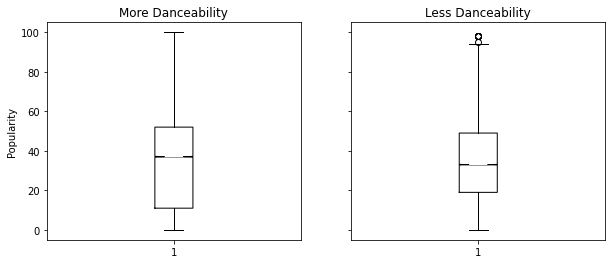

In [ ]:
# Box plot
fig,ax = plt.subplots(1,2,figsize = (10,4),sharey = True)
# x = pd.DataFrame({"More Danceability":})
ax[0].boxplot(df.loc[df["danceability_dummy"]==1,"popularity"],range(0,100,2))
ax[0].set_title("More Danceability")
ax[1].boxplot(df.loc[df["danceability_dummy"]==0,"popularity"],range(0,100,2))
ax[1].set_title("Less Danceability")
ax[0].set_ylabel('Popularity')


In [ ]:
l = df.loc[(df["danceability_dummy"]==0),"popularity"]
m = df.loc[(df["danceability_dummy"]==1),"popularity"]
stats.mannwhitneyu(m, l,alternative = "greater")

MannwhitneyuResult(statistic=3226291622.0, pvalue=1.8622925050057964e-29)

Text(0, 0.5, 'More Acousticness')

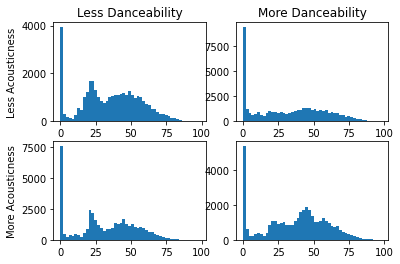

In [ ]:
fig,ax = plt.subplots(2,2)
ax[0][0].hist(df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==0),"popularity"],list(range(0,100,2)))
ax[0][1].hist(df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==1),"popularity"],list(range(0,100,2)))
ax[1][0].hist(df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==0),"popularity"],list(range(0,100,2)))
ax[1][1].hist(df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==1),"popularity"],list(range(0,100,2)))
ax[0][0].set_title("Less Danceability")
ax[0][1].set_title("More Danceability")
ax[0][0].set_ylabel("Less Acousticness")
ax[1][0].set_ylabel("More Acousticness")

Text(0, 0.5, 'More Accoustic')

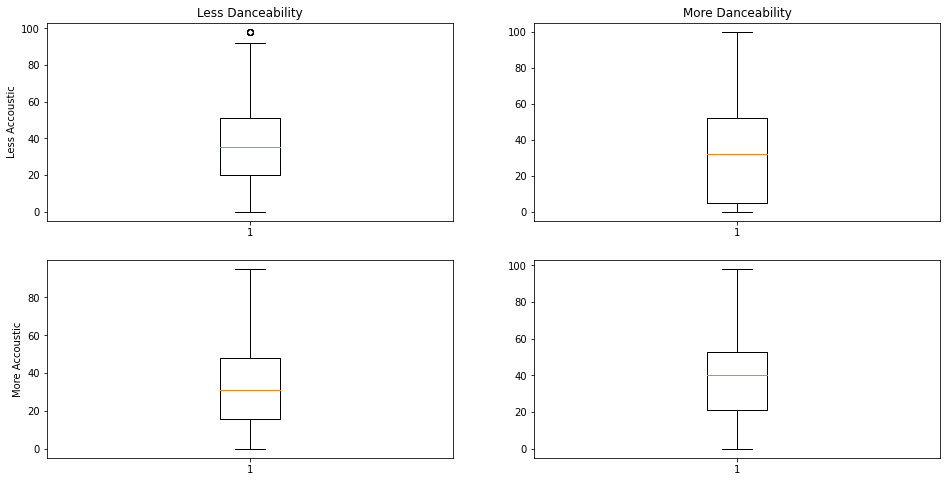

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (16,8))
ax[0][0].boxplot(df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==0),"popularity"])
ax[0][0].set_title("Less Danceability")
ax[0][1].boxplot(df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==1),"popularity"])
ax[0][1].set_title("More Danceability")
ax[1][0].boxplot(df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==0),"popularity"])

ax[1][1].boxplot(df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==1),"popularity"])
ax[0][0].set_ylabel("Less Accoustic")
ax[1][0].set_ylabel("More Accoustic")

In [ ]:
# Test 1: Given both types of music are less accoustic, would more danceability have higher popularity?
# We use Mannwhitneyu because the normality does not hold.

ll =  df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==0),"popularity"]
lm = df.loc[(df["accoustic_dummy"]==0)&(df["danceability_dummy"]==1),"popularity"]

In [ ]:
# for less accoustic sound, more danceability is significantly less popular
stats.mannwhitneyu(lm, ll,alternative = "less")

MannwhitneyuResult(statistic=705173009.0, pvalue=1.3129509696923471e-77)

In [ ]:
# Test 2: Given both types of music are more accoustic, would more danceability have higher popularity?
# We use Mannwhitneyu because the normality does not hold.

ml = df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==0),"popularity"]
mm = df.loc[(df["accoustic_dummy"]==1)&(df["danceability_dummy"]==1),"popularity"]

In [ ]:
# for more accoustic music, more danceability is significantly more popular
stats.mannwhitneyu(mm, ml,alternative = "greater")

MannwhitneyuResult(statistic=901041025.0, pvalue=1.0288258105215339e-264)

### Prediction Question

In [ ]:
# Do the tracks that have higher danceability more popular?
by_genre = df[["track_genre","danceability","popularity","acousticness"]].groupby("track_genre").mean().sort_values(by = "popularity",ascending = False)

In [ ]:
by_genre["acc_dummy"] = pd.qcut(by_genre["acousticness"], 2, labels=range(2))

In [ ]:
by_genre.head()

,danceability,popularity,acousticness,acc_dummy
track_genre,,,,
pop-film,0.606480,59.853377,0.422259,1
k-pop,0.650006,55.014548,0.319923,1
chill,0.663127,53.144224,0.535341,1
sad,0.690191,52.076765,0.489168,1
indian,0.599586,49.844314,0.452780,1


In [ ]:
# No Train Test Split
features = ['danceability']
X_less = by_genre.loc[by_genre["acc_dummy"]==0,features]
y_less = by_genre.loc[by_genre["acc_dummy"]==0,"popularity"]/100
d = pd.concat([X_less,y_less],axis = 1)
model = sm.ols("popularity ~ " + " + ".join(features) ,data = d)
model_less = model.fit()
model_less.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.101
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.153
Time:                        02:18:49   Log-Likelihood:                 50.576
No. Observations:                  57   AIC:                            -97.15
Df Residuals:                      55   BIC:                            -93.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4213      0.071      5.922      0.000       0.279       0.564
danceability    -0.1708      0.118     -1.449      0.153      -0.407       0.065
==============================================================================
Omnibus:                        2.877   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.239
Skew:                          -0.339   Prob(JB):                        0.326
Kurtosis:                       2.305   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
features = ['danceability']
X_more = by_genre.loc[by_genre["acc_dummy"]==1,features]
y_more = by_genre.loc[by_genre["acc_dummy"]==1,"popularity"]/100
d = pd.concat([X_more,y_more],axis = 1)
model = sm.ols("popularity ~ " + " + ".join(features) ,data = d)
model_more = model.fit()
model_more.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     11.78
Date:                Wed, 21 Dec 2022   Prob (F-statistic):            0.00115
Time:                        02:18:49   Log-Likelihood:                 44.547
No. Observations:                  57   AIC:                            -85.09
Df Residuals:                      55   BIC:                            -81.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0832      0.078      1.065      0.291      -0.073       0.240
danceability     0.4816      0.140      3.432      0.001       0.200       0.763
==============================================================================
Omnibus:                        3.091   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.489
Skew:                          -0.382   Prob(JB):                        0.288
Kurtosis:                       2.319   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R^2 and RMSE for Percentage popularity v.s. Danceability with Less Acousticness are 0.036794600603737515 and 0.09963492837951707 
The R^2 and RMSE for Percentage popularity v.s. Danceability with More Acousticness are 0.1763680209256001 and 0.11075226510994794 


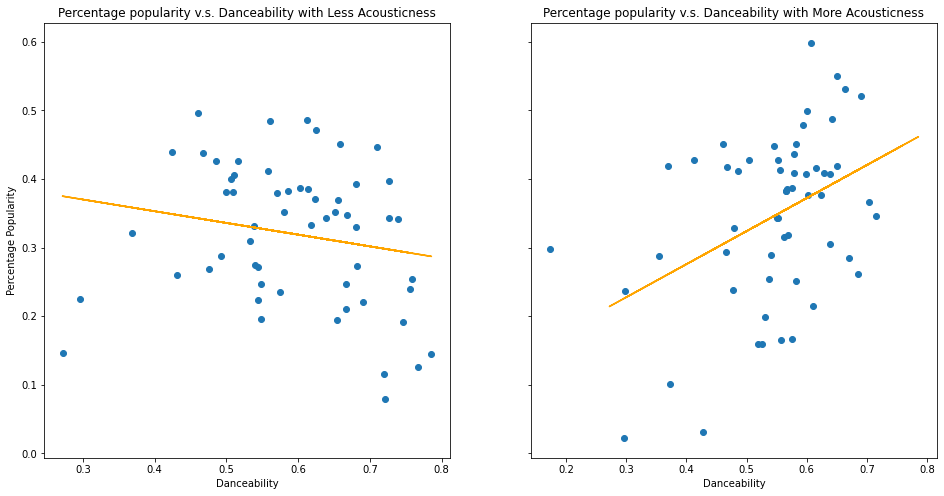

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (16,8),sharey = True)
ax[0].scatter(X_less,y_less)
ax[1].scatter(X_more,y_more)
ax[0].plot(X_less, model_less.params[1]*X_less+model_less.params[0],color = "orange")
ax[1].plot(X_less, model_more.params[1]*X_less+model_more.params[0],color = "orange")
ax[0].set_title("Percentage popularity v.s. Danceability with Less Acousticness")
ax[1].set_title("Percentage popularity v.s. Danceability with More Acousticness")
ax[0].set_ylabel("Percentage Popularity")
ax[0].set_xlabel("Danceability")
ax[1].set_xlabel("Danceability")
y_pred_less = model_less.predict(X_less)
y_pred_more = model_more.predict(X_more)
print(f"The R^2 and RMSE for Percentage popularity v.s. Danceability with Less Acousticness are {r2_score(y_less,y_pred_less)} and {mean_squared_error(y_less,y_pred_less,squared = False)} ")
print(f"The R^2 and RMSE for Percentage popularity v.s. Danceability with More Acousticness are {r2_score(y_more,y_pred_more)} and {mean_squared_error(y_more,y_pred_more,squared = False)} ")

### Classification Question

Different models to predict populatiry

In [ ]:
df=preprocessing(pd.read_csv("dataset.csv"),True)
df=df.drop(columns=['accoustic_dummy', 'danceability_dummy', 'tempo_dummy'])

In [ ]:
df_c=df.copy()
#df_c['explicit'] = df_c['explicit'].astype(int)
df_c['track_genre']=pd.Categorical(df_c['track_genre'])
df_c['track_genre']=df_c['track_genre'].cat.codes
df_c=df_c[df_c['popularity']>0]
df_c.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,0
2,1iJBSr7s7jYXzM8EGcbK5b,ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.132,0.143,181.740,3,0


In [ ]:
X=df_c.iloc[:,6:].values
Xcol=df_c.iloc[:,6:].columns
X=StandardScaler().fit_transform(X)
y=df_c['popularity'].values
X.shape

(135033, 14)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =17312218)
XGBreg=XGBRegressor(scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.3,
                      subsample = 0.8,
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=10, 
                      gamma=1)

grid=dict()
grid['alpha']=np.arange(0,0.5,0.05)
rf_grid = GridSearchCV(estimator = Ridge(), param_grid = grid, scoring='neg_mean_squared_error')
res=rf_grid.fit(X_train, y_train)
ridge=Ridge(alpha=res.best_params_['alpha'])
rf_grid = GridSearchCV(estimator = Lasso(), param_grid = grid, scoring='neg_mean_squared_error')
res=rf_grid.fit(X_train, y_train)
lasso=Lasso(alpha=res.best_params_['alpha'])
decision_tree=tree.DecisionTreeRegressor()

In [ ]:
def prediction_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.round(mean_squared_error(y_test, y_pred, squared=False),4)
    r2 = np.round(r2_score(y_test, y_pred),4)
    return [mse,r2]
res=[['XGBRegressor']+prediction_model(XGBreg, X_train, y_train, X_test, y_test)
  ,['Ridge']+prediction_model(ridge, X_train, y_train, X_test, y_test)
  ,['Lasso']+prediction_model(lasso, X_train, y_train, X_test, y_test)
  ,['Decision Tree']+prediction_model(decision_tree, X_train, y_train, X_test, y_test)]
res=pd.DataFrame(res, columns =['model','RMSE','R-Squared'])
res

[02:19:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model,RMSE,R-Squared
0,XGBRegressor,12.6761,0.5746
1,Ridge,18.8059,0.0637
2,Lasso,18.8059,0.0637
3,Decision Tree,15.2321,0.3858


Text(0.5, 1.0, 'Model Comparison')

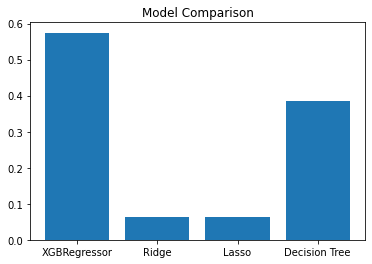

In [ ]:
plt.bar(res['model'], res['R-Squared'])
plt.title('Model Comparison')

In [ ]:
xgb_model = XGBreg.fit(X_train, y_train)
xgb_ftr_imp = xgb_model.feature_importances_
xgb_ftr_imp

[02:21:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.05239394, 0.03302295, 0.03524448, 0.02035868, 0.04421954,
       0.02006799, 0.03452286, 0.0457687 , 0.04705743, 0.03124817,
       0.03610797, 0.0380221 , 0.0234033 , 0.5385618 ], dtype=float32)

In [ ]:
decision_tree_model = decision_tree.fit(X_train, y_train)
decision_tree_ftr_imp = decision_tree_model.feature_importances_
decision_tree_ftr_imp

array([0.00609068, 0.07799823, 0.06988272, 0.0264502 , 0.07370738,
       0.00735435, 0.07206003, 0.08875308, 0.08541667, 0.05921364,
       0.07764079, 0.06834774, 0.00477266, 0.28231183])

In [ ]:
a=['XGBRegressor','Decision Tree']
ftr_imp=pd.DataFrame(np.transpose([Xcol,xgb_ftr_imp,decision_tree_ftr_imp]),columns=['feature','XGB_importance','Decision_Tree_importance'])
ftr_imp

,feature,XGB_importance,Decision_Tree_importance
0,explicit,0.052394,0.006091
1,danceability,0.033023,0.077998
2,energy,0.035244,0.069883
3,key,0.020359,0.02645
4,loudness,0.04422,0.073707
5,mode,0.020068,0.007354
6,speechiness,0.034523,0.07206
7,acousticness,0.045769,0.088753
8,instrumentalness,0.047057,0.085417
9,liveness,0.031248,0.059214


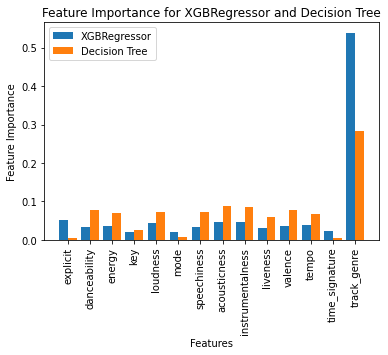

In [ ]:
X_axis = np.arange(len(Xcol))
plt.bar(X_axis - 0.2, xgb_ftr_imp, 0.4, label = 'XGBRegressor')
plt.bar(X_axis + 0.2, decision_tree_ftr_imp, 0.4, label = 'Decision Tree')
  
plt.xticks(X_axis, Xcol,rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance for XGBRegressor and Decision Tree")
plt.legend()
plt.show()

K-Modes Clustering

In [ ]:
ftr_imp[['feature','XGB_importance']].sort_values(by='XGB_importance',ascending=False).head(5)

,feature,XGB_importance
13,track_genre,0.538562
0,explicit,0.052394
8,instrumentalness,0.047057
7,acousticness,0.045769
4,loudness,0.04422


In [ ]:
ftr_imp[['feature','Decision_Tree_importance']].sort_values(by='Decision_Tree_importance',ascending=False).head(5)

,feature,Decision_Tree_importance
13,track_genre,0.282312
7,acousticness,0.088753
8,instrumentalness,0.085417
1,danceability,0.077998
10,valence,0.077641


In [ ]:
df_k=df_c.copy()
df_k['acousticness'][df_k['acousticness']<0.5]=0
df_k['acousticness'][df_k['acousticness']>=0.5]=1
df_k['instrumentalness'][df_k['instrumentalness']<0.5]=0
df_k['instrumentalness'][df_k['instrumentalness']>=0.5]=1
X=df_k[['track_genre','acousticness','instrumentalness']].values
#X[:,1:]=(X[:,1:]-X[:,1:].mean())/(X[:,1:].std())
X

array([[  0.,   0.,   0.],
       [  0.,   1.,   0.],
       [  0.,   0.,   0.],
       ...,
       [113.,   1.,   0.],
       [113.,   0.,   0.],
       [113.,   1.,   0.]])

In [ ]:
kres = []

for i in range(2,7):
    kmode = KModes(n_clusters=i, random_state=17312218, init = "Cao", n_init = 1, verbose=1)
    print(i)
    kmode.fit(X, categorical =[0])
    kres.append(kmode.cost_)

2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 154798.0
3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 139748.0
4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 139605.0
5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 138289.0
6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 137197.0


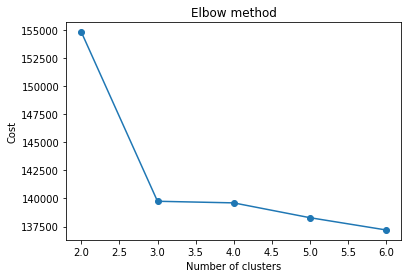

In [ ]:
plt.plot(range(2,7), kres, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

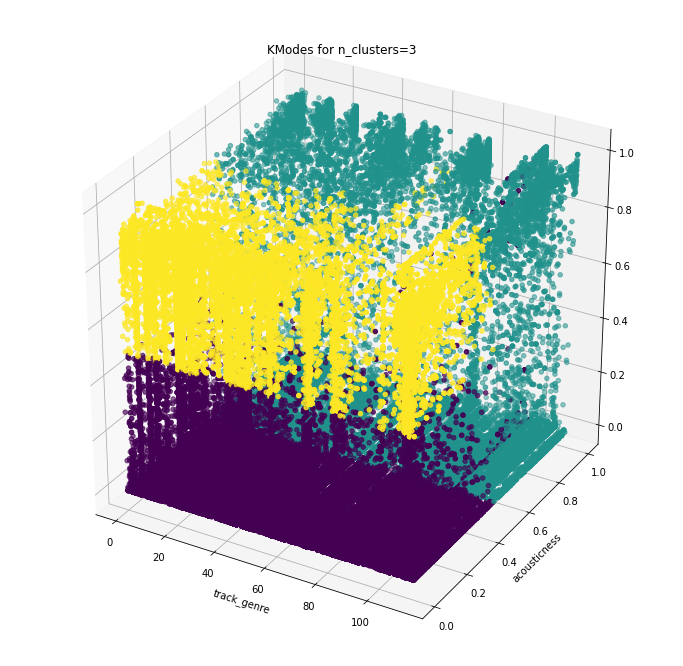

In [ ]:
kmode = KModes(n_clusters=3)
kmode.fit(X)
df_k=df_c.copy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], df_k['acousticness'], df_k['instrumentalness'],c=kmode.labels_)
plt.title("KModes for n_clusters=3")
plt.xlabel('track_genre')
plt.ylabel('acousticness')
plt.show()

In [ ]:
kmode.labels_

array([0, 1, 0, ..., 1, 0, 1], dtype=uint16)

In [ ]:
df_c['cluster'] = kmode.labels_.tolist()
df_c.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,0,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,0,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.132,0.143,181.740,3,0,1


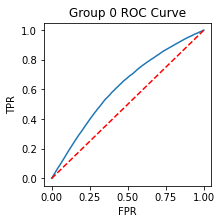

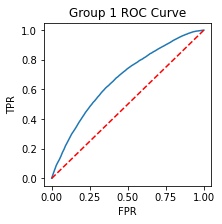

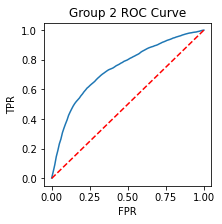

In [ ]:
Loreg=[]
for i in df_c['cluster'].sort_values().unique().tolist():
  df_ml=df_c[df_c['cluster']==i].copy()
  df_ml['popularity'][df_ml['popularity']<df_ml['popularity'].median()]=0
  df_ml['popularity'][df_ml['popularity']>=df_ml['popularity'].median()]=1
  X=df_ml.iloc[:,6:-1].values
  Xcol=df_ml.iloc[:,6:-1].columns
  Y=df_ml['popularity'].values
  kfold=KFold(n_splits=10, random_state=17312218, shuffle=True)
  model=LogisticRegression()
  tprs=[]
  mean_fpr = np.linspace(0, 1, 100)
  for train,test in kfold.split(X, Y):
    prediction = model.fit(X[train],Y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(Y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  random_classifier=np.linspace(0.0, 1.0, 100)
  plt.figure(figsize=(3, 3))
  plt.plot(mean_fpr, mean_tpr)
  plt.plot(random_classifier, random_classifier, "r--")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("Group "+str(i)+" ROC Curve")
  plt.show()
  Loreg.append([i,mean_auc]+list(model.coef_[0]))

In [ ]:
Loreg=pd.DataFrame(Loreg, columns =['cluster','AUC']+list(Xcol))
Loreg

,cluster,AUC,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,0.618158,0.010531,0.947503,-1.573538,0.002911,0.104899,-0.126184,-0.824961,0.262199,-0.698201,-0.516642,-0.859651,-0.000677,0.436272,-0.000632
1,1,0.670206,0.023346,0.979153,-0.139684,-0.001170,0.024392,0.040559,-1.373940,-1.101114,-0.638594,-0.865891,-1.418448,0.005031,0.325105,-0.000724
2,2,0.741228,-0.169301,1.200727,-0.679075,0.006269,0.035248,0.003087,-0.687152,0.910965,-0.508298,-0.171403,-1.736607,-0.003976,0.006205,0.020902


In [ ]:
df_c['cluster'].sort_values().unique().tolist()

[0, 1, 2]

In [ ]:
(Loreg.iloc[0,1]*np.count_nonzero(kmode.labels_==0)+Loreg.iloc[1,1]*np.count_nonzero(kmode.labels_==1)+Loreg.iloc[2,1]*np.count_nonzero(kmode.labels_==2))/len(kmode.labels_)

0.6453995054958461

### Extra Credit: Is pop music more popular than non-pop music?


In [ ]:
df.loc[df["track_genre"].str.contains("pop"),["track_genre","popularity"]].shape

(12254, 2)

In [ ]:
pops = df.loc[df["track_genre"].str.contains("pop"),["track_genre","popularity"]].groupby("track_genre").mean().dropna()
non_pops = df.loc[~df["track_genre"].str.contains("pop"),["track_genre","popularity"]].groupby("track_genre").mean().dropna()

Text(0, 0.5, 'Popularity')

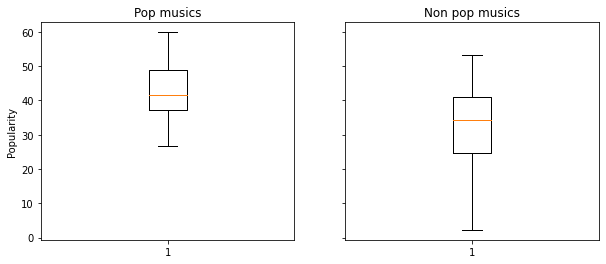

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (10,4),sharey = True)
# x = pd.DataFrame({"More Danceability":})
ax[0].boxplot(pops["popularity"])
ax[0].set_title("Pop musics")
ax[1].boxplot(non_pops["popularity"])
ax[1].set_title("Non pop musics")
ax[0].set_ylabel('Popularity')

In [ ]:
stats.mannwhitneyu(pops["popularity"],non_pops["popularity"],alternative = "greater")

MannwhitneyuResult(statistic=712.0, pvalue=0.0060118116604104006)